In [15]:
# http://www.robesafe.uah.es/personal/eduardo.romera/uah-driveset/

# http://www.robesafe.uah.es/personal/eduardo.romera/pdfs/Romera16itsc.pdf
# pdf contains description of data (what each column means)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

import os

from ride_parser import RideParser
from app_data_parser import get_data_from_app
from PIL import Image

Objetivos:
- [] Gerar mapa com a rota feita por cada um dos motoristas
- [] Sincronizar vídeo com eventos de aceleração

In [11]:
ride_root_dir = os.path.join("UAH-DRIVESET-v1", "D1", "20151110175712-16km-D1-NORMAL1-SECONDARY")

ride = RideParser(ride_root_dir)

# col_names = [str(i) for i in range(13)]
# col_names = ["timestamp", "speed", "lat", "long", "altitude", "vert accuracy", "horiz accuracy", "course", "difcourse", "?1", "?2", "?3", "?4"]
# pd.read_csv(gps_file_path, sep=" ", names=col_names)

ride.gps_df
ride.accelerometer_df

,timestamp,is speed gt 50 kmh,acc_x,acc_y,acc_z,filtered_acc_x,filtered_acc_y,filtered_acc_z,roll_degrees,pitch_degrees,yaw_degrees,?1,?2,?3,?4
0,6.94,1,0.017,-0.011,0.018,-0.005,0.008,0.018,-1.523,0.015,0.012,NaN,NaN,NaN,NaN
1,7.03,1,0.046,0.007,0.019,0.016,-0.002,0.018,-1.522,0.012,0.012,NaN,NaN,NaN,NaN
2,7.14,1,0.052,-0.016,0.027,0.037,-0.005,0.018,-1.520,0.014,0.011,NaN,NaN,NaN,NaN
3,7.24,1,0.015,-0.016,0.026,0.038,-0.009,0.024,-1.523,0.014,0.011,NaN,NaN,NaN,NaN
4,7.34,1,-0.014,-0.017,0.040,0.012,-0.016,0.032,-1.525,0.012,0.011,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6165,630.54,1,-0.051,0.096,0.023,-0.046,0.073,0.003,-1.534,-0.013,-1.265,NaN,NaN,NaN,NaN
6166,630.64,1,0.036,0.085,0.006,-0.018,0.069,0.015,-1.534,-0.012,-1.271,NaN,NaN,NaN,NaN
6167,630.75,1,0.045,0.028,-0.011,0.024,0.058,0.001,-1.532,-0.011,-1.272,NaN,NaN,NaN,NaN
6168,630.84,1,-0.031,0.063,-0.011,0.010,0.053,-0.011,-1.531,-0.009,-1.278,NaN,NaN,NaN,NaN


In [12]:
def foo(accelerometer_df, frame_granularity, delta_time_size, img_id):
    fig, axs = plt.subplots(ncols=1, nrows=3)

    lower_limit = frame_granularity * img_id 
    upper_limit = frame_granularity * img_id + delta_time_size
    print("low up", lower_limit, upper_limit)
    time_filter = (accelerometer_df.timestamp >= lower_limit) & (accelerometer_df.timestamp < upper_limit)
    filtered_accelerations_df = accelerometer_df[time_filter]

    acc_x = filtered_accelerations_df["acc_x"]
    acc_y = filtered_accelerations_df["acc_y"]
    acc_z = filtered_accelerations_df["acc_z"]
    timestamp = filtered_accelerations_df["timestamp"]

    # axs[0].scatter(timestamp, acc_x, s=0.1)
    axs[0].plot(timestamp, filtered_accelerations_df["acc_x"], label="acc_x")
    axs[0].plot(timestamp, filtered_accelerations_df["filtered_acc_x"], label="filt_acc_x")
    axs[0].legend(loc='right')
    axs[0].set_title("acc_x")

    axs[1].plot(timestamp, acc_y)
    axs[1].plot(timestamp, filtered_accelerations_df["filtered_acc_y"])
    axs[1].set_title("acc_y")

    axs[2].plot(timestamp, acc_z)    
    axs[2].plot(timestamp, filtered_accelerations_df["filtered_acc_z"])
    axs[2].set_title("acc_z")

    for ax in axs:
        ax.set_ylim(-0.2, 0.2)
        ax.set_xlim(lower_limit, upper_limit)

    # axs.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

    # fig.ylim(-0.2, 0.2)
    fig.tight_layout()

    fig_name = os.path.join("images", "fig_%02d" % i)
    fig.savefig(fig_name)

    plt.close(fig)

qtty_frames 610
oldest_timestamp 630


KeyboardInterrupt: 

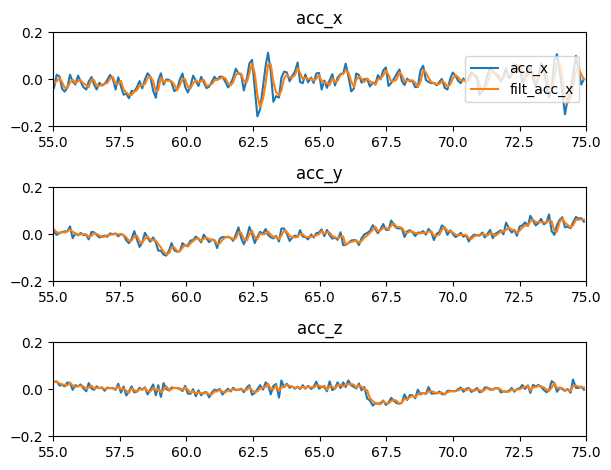

In [14]:
accelerometer_df = ride.accelerometer_df
oldest_timestamp = int(accelerometer_df.timestamp.iloc[-1])
delta_time_size = 20
frame_granularity = 1
qtty_frames = (oldest_timestamp - delta_time_size) // frame_granularity

print("qtty_frames", qtty_frames)
print("oldest_timestamp", oldest_timestamp)

for i in range(qtty_frames):
    with ProcessPoolExecutor(max_workers=10) as executor:
        future = executor.submit(foo, accelerometer_df, frame_granularity, delta_time_size, i)

    # print(future.result())

# plt.show()
# RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

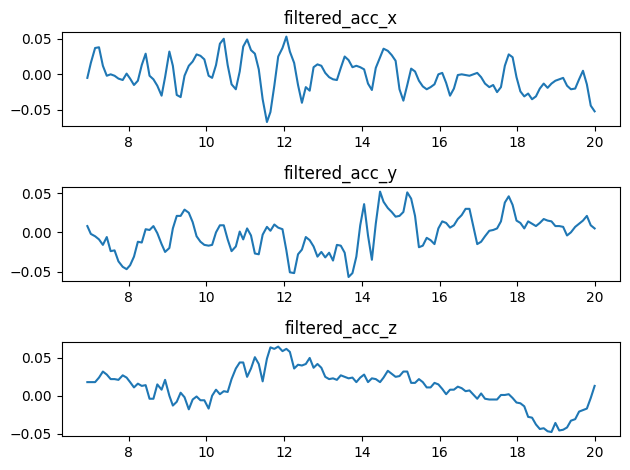

In [5]:
fig, axs = plt.subplots(ncols=1, nrows=3)

accelerometer_df = ride.accelerometer_df
accelerometer_df = accelerometer_df[accelerometer_df.timestamp < 20]
filtered_acc_x = accelerometer_df["filtered_acc_x"]
filtered_acc_y = accelerometer_df["filtered_acc_y"]
filtered_acc_z = accelerometer_df["filtered_acc_z"]
timestamp = accelerometer_df["timestamp"]

# axs[0].scatter(timestamp, filtered_acc_x, s=0.1)
axs[0].plot(timestamp, filtered_acc_x) #, "-o")
axs[0].set_title("filtered_acc_x")

axs[1].plot(timestamp, filtered_acc_y)
axs[1].set_title("filtered_acc_y")

axs[2].plot(timestamp, filtered_acc_z)
axs[2].set_title("filtered_acc_z")

fig.tight_layout()

plt.show()

In [6]:
app_data = get_data_from_app()

velocities = app_data["SPEED"]
plt.plot(velocities["timestamp"], velocities["SPEED"])
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '..\\Dados_app\\DELETEME.txt'

In [ ]:
# imgs = ride.generate_acc_sub_graph()

# im = Image.open(next(imgs))
# im.show(title="My Image")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

import numpy
from PIL import Image

n = 20

img = [] # some array of images
for i in range(n):
	imarray = numpy.random.rand(100,100,3) * 255
	im = Image.fromarray(imarray.astype('uint8')).convert('RGBA')
	img.append(im)

frames = [] # for storing the generated images
fig = plt.figure()
for i in range(n):
	frames.append([plt.imshow(img[i], cmap=cm.Greys_r,animated=True)])

ani = animation.ArtistAnimation(fig, frames, blit=True)

writergif = animation.PillowWriter(fps=1)
ani.save('movie.gif', writer=writergif)
plt.show()

In [ ]:
import io
from PIL import Image
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.figure()
plt.plot([1, 2])

img_buf = io.BytesIO()
plt.savefig(img_buf, format='png')

im = Image.open(img_buf)
im.show(title="My Image")

img_buf.close()